# Guider Performance Studies

In [25]:
%matplotlib inline

In [26]:
import numpy as np
import matplotlib.pyplot as plt

In [88]:
from pathlib import Path
from collections import defaultdict
import json
import os

In [28]:
import fitsio

In [143]:
# Used to load guider json results
import desietcimg.gfa

## Find Long Guide Sequences

Look for guide sequences using PlateMaker within the range of dates covered by v3 offline reductions:

In [20]:
def get_guide_stars(night, expid):
    """Lookup the number of guide stars per camera in the json file.
    """
    cameras = ('GUIDE0', 'GUIDE2', 'GUIDE3', 'GUIDE5', 'GUIDE7', 'GUIDE8')
    ROOT = Path('/project/projectdirs/desi/spectro/data/')
    night = str(night)
    # Read the json file of guider outputs.
    jsonpath = ROOT / night / expid / f'centroids-{expid}.json'
    if not jsonpath.exists():
        raise ValueError('Non-existent path: {0}.'.format(jsonpath))
    with open(jsonpath) as f:
        D = json.load(f)
        assert D['expid'] == int(expid)
    # Use the first frame to lookup the guide stars for each camera.
    frame0 = D['frames'].get('1')
    if frame0 is None:
        return None
    stars = {G: len([K for K in frame0.keys() if K.startswith(G)]) for G in cameras}
    return stars

In [24]:
def findPM(first=20200119, last=20200127, minframes=150):
    cameras = ('GUIDE0', 'GUIDE2', 'GUIDE3', 'GUIDE5', 'GUIDE7', 'GUIDE8')
    ROOT = Path('/project/projectdirs/desi/spectro/data/')
    for nightpath in sorted(list(ROOT.glob('????????'))):
        night = int(str(nightpath)[-8:])
        if night < first or night >= last:
            continue
        for exppath in nightpath.glob('????????'):
            expid = str(exppath)[-8:]
            guidepath = exppath / f'guide-{expid}.fits.fz'
            if not guidepath.exists():
                continue
            hdr = fitsio.read_header(str(guidepath), ext='GUIDER')
            nframes = hdr['FRAMES']
            if nframes < minframes:
                continue
            try:
                PlateMaker = fitsio.read(str(guidepath), ext='PMGSTARS')
                nstars = [np.count_nonzero(PlateMaker['GFA_LOC'] == camera) for camera in cameras]
                status = 'PM'
            except IOError as e:
                continue
                PlateMaker = None
                stars = get_guide_stars(night, expid)
                if stars is None:
                    continue
                nstars = [stars.get(camera, 0) for camera in cameras]
                status = 'json'
            print(f'{night} {expid} {nframes:3d} {",".join(str(n) for n in nstars)} {status}')

findPM()

20200119 00042165 185 3,0,4,3,5,3 PM
20200122 00043029 158 1,5,5,0,2,5 PM
20200122 00043027 154 5,3,5,0,2,5 PM
20200124 00043864 174 3,2,5,3,5,5 PM
20200124 00043860 236 3,2,5,3,5,5 PM
20200125 00044102 245 5,5,5,5,5,5 PM
20200125 00044239 236 2,5,3,0,2,1 PM
20200125 00044280 297 1,2,4,5,3,3 PM
20200126 00044452 228 5,5,5,5,5,5 PM
20200126 00044447 253 5,5,5,5,5,5 PM
20200126 00044383 246 2,3,5,0,5,5 PM


## Common Plotting and Metrics

Define a common plotting and metric calculation code for all centroid methods:

In [113]:
def plot_centroids(ax, t, x, conv, symbol='.', color=None, label='', offset=0, clip=5):
    # Clip outliers relative to the unclipped median.
    x0 = np.nanmedian(x)
    sel = np.isfinite(x)
    sel[sel] &= np.abs(x[sel] - x0) < clip
    if not np.any(sel):
        return np.nan
    # Fit a line to the clipped values.
    p1x, p0x = np.polyfit(t[sel], x[sel], deg=1)
    xfit = p0x + t * p1x
    # Recenter using the line fit and any requested offset.
    tmid = 0.5 * (t[0] + t[-1])
    x0 = p0x + tmid * p1x - offset
    # Plot the best fit line.
    line2d = ax.plot(t, xfit - x0, '-', c=color, lw=2, alpha=0.5)
    c = line2d[0].get_color()
    # Calculate the spread of clipped values relative to the line.
    std = conv * np.std(x[sel] - xfit[sel])
    # Plot the data.
    ax.plot(t[sel], x[sel] - x0, '-', c=c, alpha=0.25)
    ax.plot(t[sel], x[sel] - x0, symbol, c=c, label='{0}{1:.1f} mas'.format(label, std))
    return std

## Offline Reductions

Load and plot Aaron Meisner's v3 offline reductions described in [desi-commiss 4078]

In [30]:
V3g = Path('/global/cscratch1/sd/ameisner/reduced/v0003_guide')
assert V3g.exists()

Load and plot offline centroids:

In [124]:
def plot_offline_centroids(night, expid, camera, maxdxy=3.75, nstars=5, save=None):
    night = str(night)
    expid = f'{expid:08d}'
    path = V3g / night / expid
    assert path.exists()

    '''
    # Extract metadata per guide frame from the ccds files.
    ccd_cols = ('transparency', 'fiber_fracflux', 'fwhm_asec', 'sky_mag_ab')
    all_cols = ccd_cols
    series = {}
    for col in all_cols:
        series[col] = defaultdict(list)
    for k, ccd in enumerate(sorted(list(path.glob(f'guide-{expid}_ccds-?????.fits')))):
        data = fitsio.read(str(ccd), ext=1)
        for row in data:
            if row['camera'] != camera:
                continue
            for col in ccd_cols:
                series[col][camera].append(row[col])
    fig, ax = plt.subplots(len(all_cols), 1, figsize=(12, 3 * len(all_cols)), sharex=True)
    for k, col in enumerate(all_cols):
        for camera in series[col]:
            ax[k].plot(series[col][camera], '.', label=camera)
        if k == 0:
            ax[k].legend(ncol=2)
        ax[k].set_ylabel(col)
    ax[-1].set_xlabel('Guide frame #')
    plt.show()
    '''

    # Extract centroids per guide frame for GAIA matched sources.
    centroid = defaultdict(list)
    magnitude = {}
    for k, cat in enumerate(sorted(list(path.glob(f'guide-{expid}_catalog-?????.fits')))):
        data = fitsio.read(str(cat), ext=1)
        for row in data:
            if row['camera'] != camera:
                continue
            src = row['source_id']
            if src not in magnitude:
                magnitude[src] = row['phot_g_mean_mag']
            centroid[src].append((row['cube_index'], row['xcentroid'], row['ycentroid']))
    # Sort sources by increasing magnitude.
    brightest = sorted(magnitude.items(), key=lambda x: x[1])
    # Conversion from pix to mas.
    xconv, yconv = 1e3 * 15 / 70.4, 1e3 * 15 / 76.33
    # Plot centroids.
    fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
    xstd, ystd = [], []
    for (src, mag) in brightest[:nstars]:
        label = f'mag={mag:.1f},'
        t, x, y = np.array(centroid[src]).T
        xstd.append(plot_centroids(ax[0], t, x, xconv, label=label))
        ystd.append(plot_centroids(ax[1], t, y, yconv, label=label))
    ax[0].text(0.01, 0.9, f'OFFLINE $\Delta x$ {np.nanmedian(xstd):.1f} mas', fontsize=18, transform=ax[0].transAxes)
    ax[1].text(0.01, 0.9, f'OFFLINE $\Delta y$ {np.nanmedian(ystd):.1f} mas', fontsize=18, transform=ax[1].transAxes)
    ax[0].legend()
    ax[1].legend()
    ax[0].set_ylabel('$\Delta x$ [pix]')
    ax[1].set_ylabel('$\Delta y$ [pix]')
    ax[1].set_xlabel('{0} {1} {2} Frame #'.format(night, expid, camera), fontsize=14)
    ax[0].set_ylim(-maxdxy, +maxdxy)
    ax[1].set_ylim(-maxdxy, +maxdxy)
    ax[1].set_xlim(-1.5, np.max(t) + 1.5)
    plt.subplots_adjust(0.07, 0.1, 0.99, 0.99, hspace=0.03)
    if save:
        plt.savefig(save)

## Online Guider Outputs

Load and plot guider centroids and the combined corrections sent to TCS:

In [125]:
def plot_guider_centroids(night, expid, camera, maxdxy=3.75, save=None):
    """
    """
    ROOT = Path('/project/projectdirs/desi/spectro/data/')
    night = str(night)
    expid = f'{expid:08d}'
    expected, combined, centroid = desietcimg.gfa.load_guider_centroids(ROOT / night / expid, expid)
    expected, combined, centroid = expected[camera], combined[camera], centroid[camera]
    nstars, nframes = centroid.shape[0], centroid.shape[2]
    t = np.arange(nframes)
    # Conversion from pix to mas.
    xconv, yconv = 1e3 * 15 / 70.4, 1e3 * 15 / 76.33
    # Plot combined guider corrections.
    fig, ax = plt.subplots(2, 1,  figsize=(12, 6), sharex=True)
    plot_centroids(ax[0], t, combined[0], xconv, '+', 'k', 'Combined:', offset=-2)
    plot_centroids(ax[1], t, combined[1], yconv, '+', 'k', 'Combined:', offset=-2)
    # Loop over guide stars on this camera.
    xstd, ystd = [], []
    for istar in range(nstars):
        x, y = centroid[istar]
        xstd.append(plot_centroids(ax[0], t, x, xconv))
        ystd.append(plot_centroids(ax[1], t, y, yconv))
    ax[0].text(0.01, 0.9, f'GUIDER $\Delta x$ {np.nanmedian(xstd):.1f} mas', fontsize=18, transform=ax[0].transAxes)
    ax[1].text(0.01, 0.9, f'GUIDER $\Delta y$ {np.nanmedian(ystd):.1f} mas', fontsize=18, transform=ax[1].transAxes)
    ax[0].legend(ncol=nstars + 1)
    ax[1].legend(ncol=nstars + 1)
    ax[0].set_ylim(-maxdxy, +maxdxy)
    ax[1].set_ylim(-maxdxy, +maxdxy)
    ax[0].set_ylabel('$\Delta x$ [pix]')
    ax[1].set_ylabel('$\Delta y$ [pix]')
    ax[1].set_xlabel('{0} {1} {2} Frame #'.format(night, expid, camera), fontsize=14)
    ax[-1].set_xlim(-1.5, nframes + 0.5)
    plt.subplots_adjust(0.07, 0.1, 0.99, 0.99, hspace=0.03)
    if save:
        plt.savefig(save)

## Online ETC Outputs

Load and plot ETC online centroids. To generate the FITS file this reads, you will first need to run, e.g.
```
gfadiq -v --outpath $SCRATCH/gfadiq --night 20200124 --expid 43860 --guide-stars
```

In [126]:
def plot_etc_centroids(night, expid, camera, maxdxy=3.75, save=None):
    SCRATCH = Path(os.getenv('SCRATCH'))
    ROOT = SCRATCH / 'gfadiq'
    night = str(night)
    expid = f'{expid:08d}'
    results = {}
    path = ROOT / night / expid / 'gfaetc_{0}.fits'.format(expid)
    assert path.exists()
    with fitsio.FITS(str(path)) as hdus:
        assert camera+'P' in hdus, 'Missing params HDU for camera {0}'.format(camera)
        #Dsum, WDsum, Msum = hdus[camera + 'G'].read()
        params = hdus[camera + 'P'].read()
    nstars, nframes = params.shape[:2]
    t = np.arange(nframes)
    # Conversion from pix to mas.
    xconv, yconv = 1e3 * 15 / 70.4, 1e3 * 15 / 76.33
    # Plot centroids for each guide star.
    fig, ax = plt.subplots(2, 1,  figsize=(12, 6), sharex=True)
    xstd, ystd = [], []
    for istar in range(nstars):
        x, y = params[istar, :, 0], params[istar, :, 1]
        xstd.append(plot_centroids(ax[0], t, x, xconv))
        ystd.append(plot_centroids(ax[1], t, y, yconv))
    ax[0].text(0.01, 0.9, f'ETC $\Delta x$ {np.nanmedian(xstd):.1f} mas', fontsize=18, transform=ax[0].transAxes)
    ax[1].text(0.01, 0.9, f'ETC $\Delta y$ {np.nanmedian(ystd):.1f} mas', fontsize=18, transform=ax[1].transAxes)
    ax[0].legend(ncol=nstars + 1)
    ax[1].legend(ncol=nstars + 1)
    ax[0].set_ylim(-maxdxy, +maxdxy)
    ax[1].set_ylim(-maxdxy, +maxdxy)
    ax[0].set_ylabel('$\Delta x$ [pix]')
    ax[1].set_ylabel('$\Delta y$ [pix]')
    ax[1].set_xlabel('{0} {1} {2} Frame #'.format(night, expid, camera), fontsize=14)
    ax[-1].set_xlim(-1.5, nframes + 0.5)
    plt.subplots_adjust(0.07, 0.1, 0.99, 0.99, hspace=0.03)
    if save:
        plt.savefig(save)

## Comparisons for long guide sequences

### 20200119 / 42165

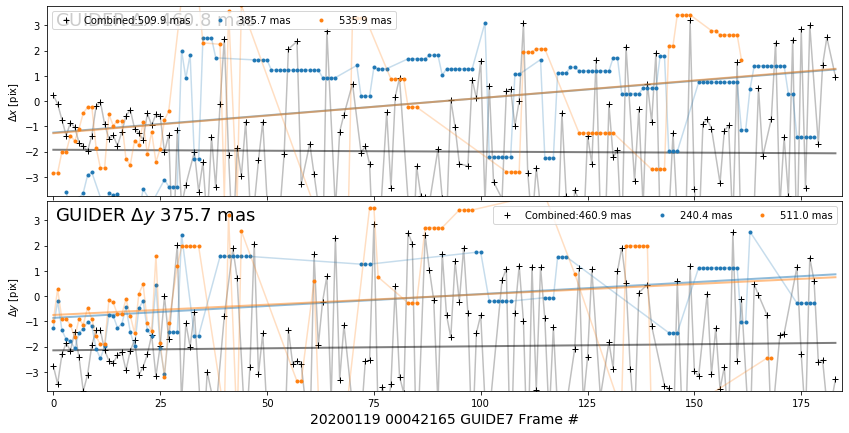

In [133]:
plot_guider_centroids(20200119, 42165, 'GUIDE7', save='guider-20200119-42165-GUIDE7.png')

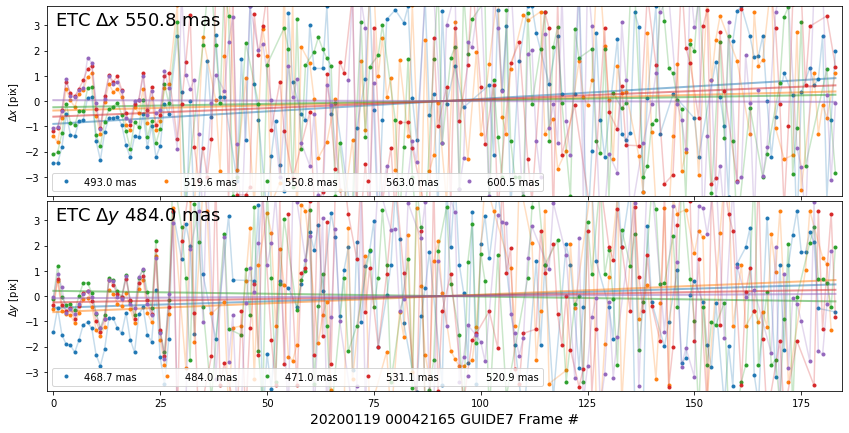

In [134]:
plot_etc_centroids(20200119, 42165, 'GUIDE7', save='etc-20200119-42165-GUIDE7.png')

/global/homes/d/dkirkby/.conda/envs/desijupyter/lib/python3.7/site-packages/ipykernel_launcher.py:54: RankWarning: Polyfit may be poorly conditioned


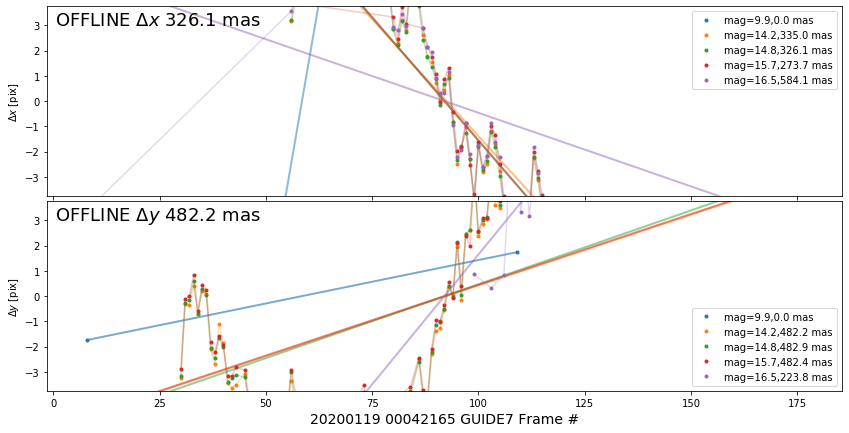

In [135]:
plot_offline_centroids(20200119, 42165, 'GUIDE7', save='offline-20200119-42165-GUIDE7.png')

### 20200122 / 43029

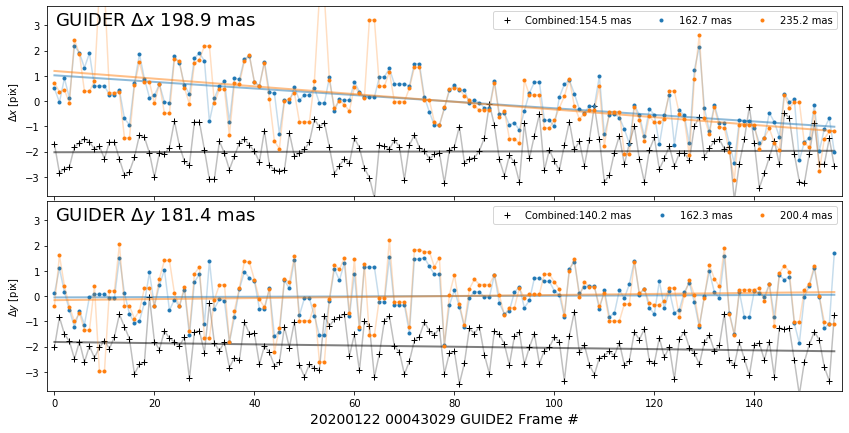

In [127]:
plot_guider_centroids(20200122, 43029, 'GUIDE2', save='guider-20200122-43029-GUIDE2.png')

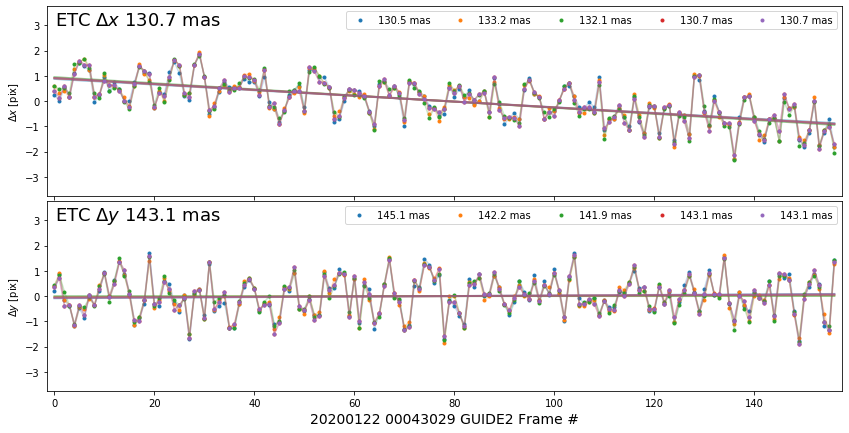

In [128]:
plot_etc_centroids(20200122, 43029, 'GUIDE2', save='etc-20200122-43029-GUIDE2.png')

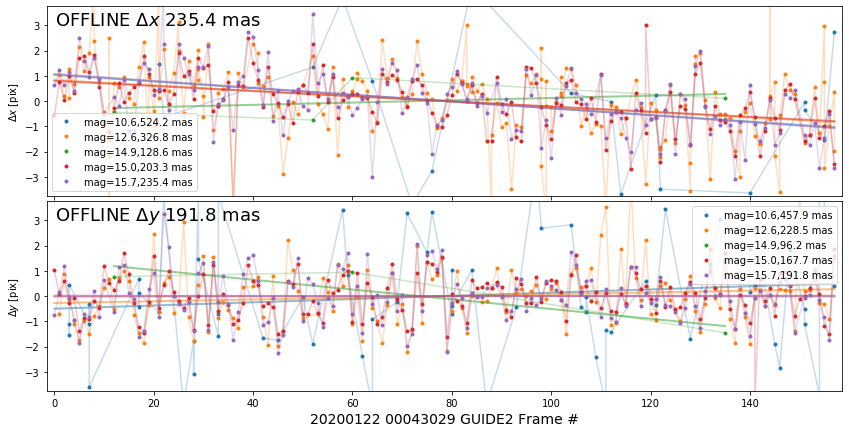

In [129]:
plot_offline_centroids(20200122, 43029, 'GUIDE2', save='offline-20200122-43029-GUIDE2.png')

### 20200124 / 43860

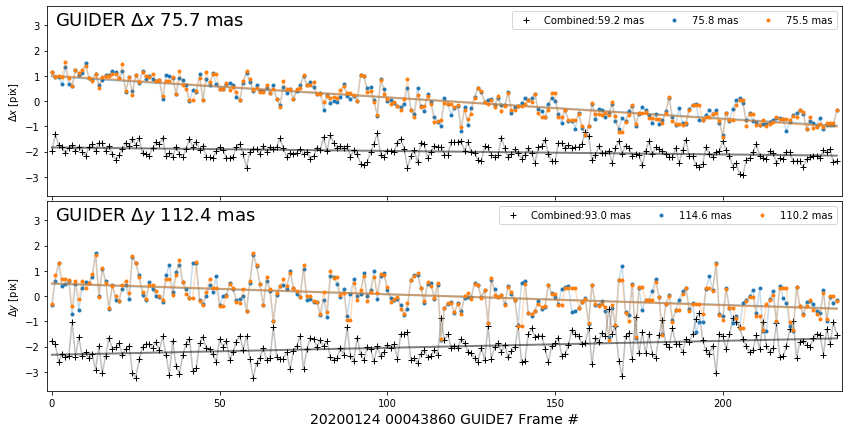

In [130]:
plot_guider_centroids(20200124, 43860, 'GUIDE7', save='guider-20200124-43860-GUIDE7.png')

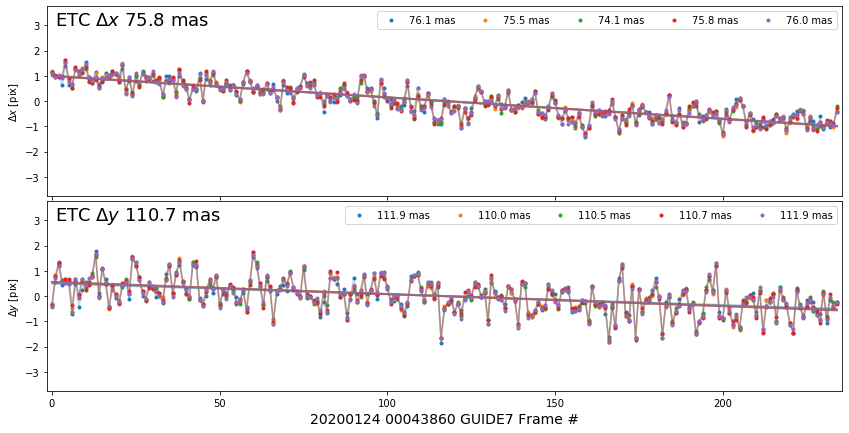

In [131]:
plot_etc_centroids(20200124, 43860, 'GUIDE7', save='etc-20200124-43860-GUIDE7.png')

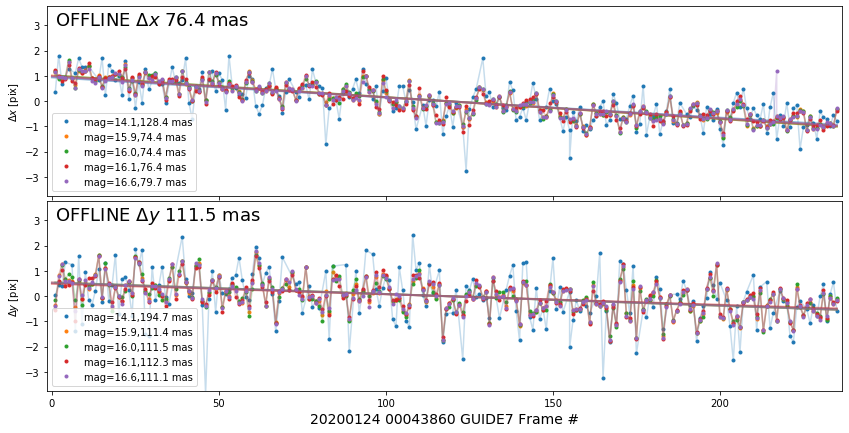

In [132]:
plot_offline_centroids(20200124, 43860, 'GUIDE7', save='offline-20200124-43860-GUIDE7.png')

### 20200125 / 44102

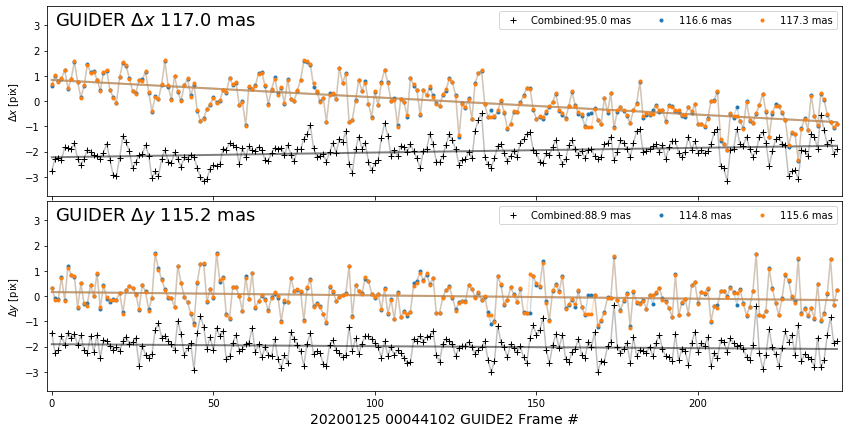

In [136]:
plot_guider_centroids(20200125, 44102, 'GUIDE2', save='guider-20200125-44102-GUIDE2.png')

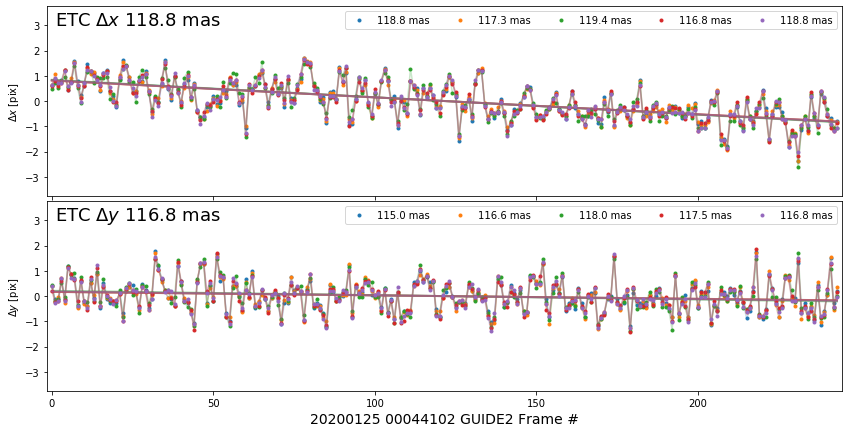

In [137]:
plot_etc_centroids(20200125, 44102, 'GUIDE2', save='etc-20200125-44102-GUIDE2.png')

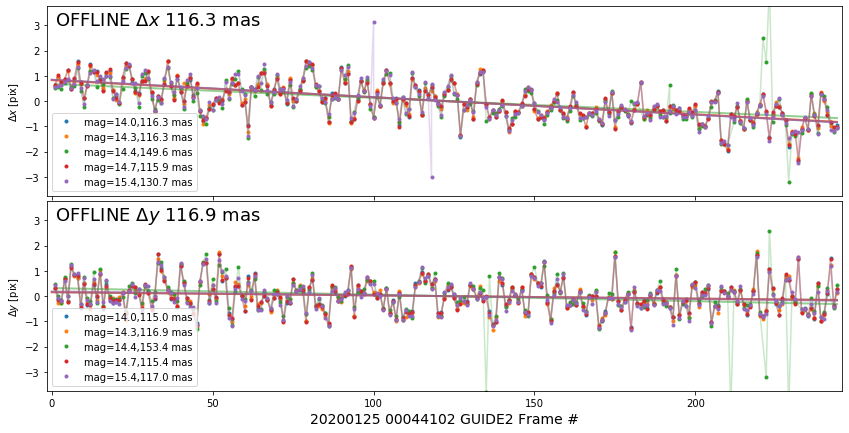

In [138]:
plot_offline_centroids(20200125, 44102, 'GUIDE2', save='offline-20200125-44102-GUIDE2.png')

### 20200126 / 44447

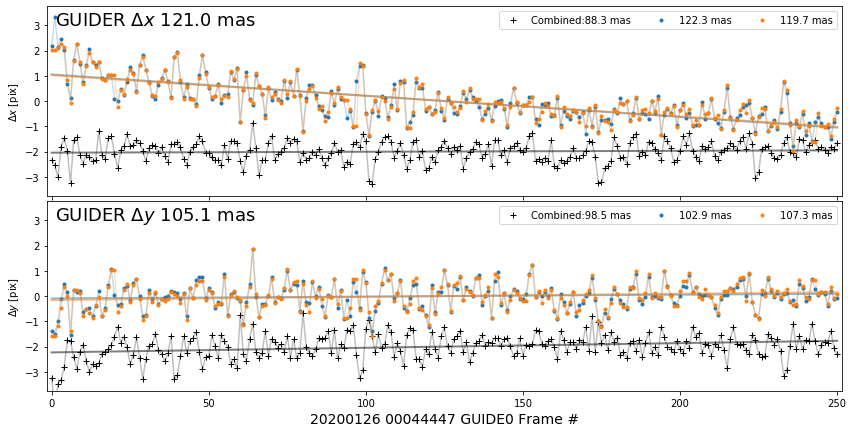

In [139]:
plot_guider_centroids(20200126, 44447, 'GUIDE0', save='guider-20200126-44447-GUIDE0.png')

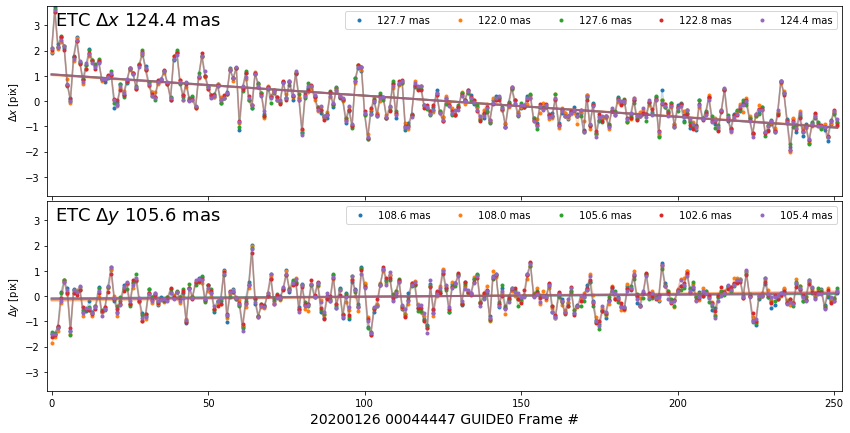

In [140]:
plot_etc_centroids(20200126, 44447, 'GUIDE0', save='etc-20200126-44447-GUIDE0.png')

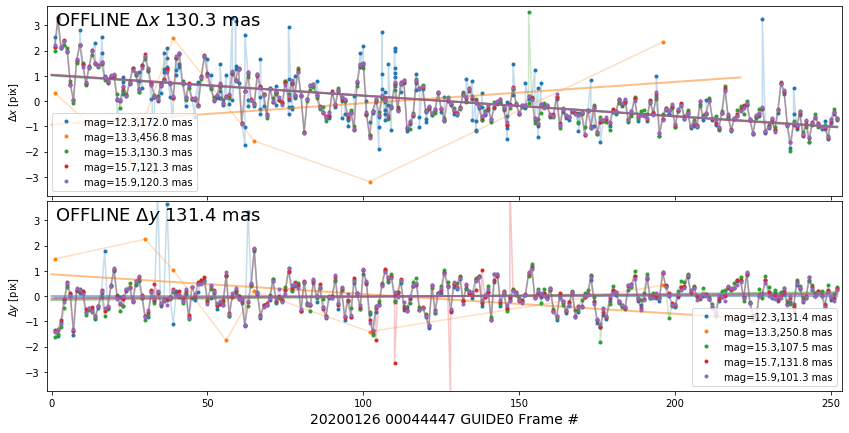

In [141]:
plot_offline_centroids(20200126, 44447, 'GUIDE0', save='offline-20200126-44447-GUIDE0.png')